# Density Matrices Scalings - Many-Body Wavefunctions

Author: Paolo Zinesi

In [106]:
import numpy as np
from numpy import random
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from scipy.optimize import curve_fit

color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# function used in fits
def exp_fit(x, C, base):
    return C * (base**x)

save_plots = False

$$\psi_i \in \mathcal{H}^D$$

$$ |\Psi \rangle = \sum_{\alpha_1,\dots,\alpha_N} \Psi_{\alpha_1,\dots,\alpha_N} |\alpha \rangle _1 \otimes \dots \otimes |\alpha \rangle _N$$

Note: a separable wavefunction numpy array with $N$ complex128 elements occupies a dimension of $16 N D$ bytes.


## Plots

### Separable and general wavefunction testing

In [96]:
wf_df = pd.read_csv("results/wavefunc_perf.csv", header=0, dtype={"N":int, "D":int, "dim_bytes":int})
wf_df

,N,D,type,dim_bytes,time
0,2,2,separable,64,0.000348
1,2,2,general,64,0.000072
2,2,2,separable,64,0.000098
3,2,2,general,64,0.000074
4,2,2,separable,64,0.000076
...,...,...,...,...,...
289,8,8,general,268435456,1.332203
290,8,8,separable,1024,0.000160
291,8,8,general,268435456,1.231001
292,8,8,separable,1024,0.000125


In [97]:
# groupby repetitions of the same configuration
# then take the average, std and rename columns 
agg_df = wf_df.groupby(["N", "D", "type", "dim_bytes"]).agg(["mean", "std"])
agg_df.columns = ['_'.join(col) for col in agg_df.columns.to_flat_index().values]
agg_df.reset_index(inplace=True)
agg_df

,N,D,type,dim_bytes,time_mean,time_std
0,2,2,general,64,0.000074,0.000002
1,2,2,separable,64,0.000174,0.000151
2,2,3,general,144,0.000079,0.000009
3,2,3,separable,96,0.000085,0.000009
4,2,4,general,256,0.000085,0.000011
...,...,...,...,...,...,...
93,8,6,separable,768,0.000132,0.000033
94,8,7,general,92236816,0.438599,0.023971
95,8,7,separable,896,0.000147,0.000030
96,8,8,general,268435456,1.260503,0.062417


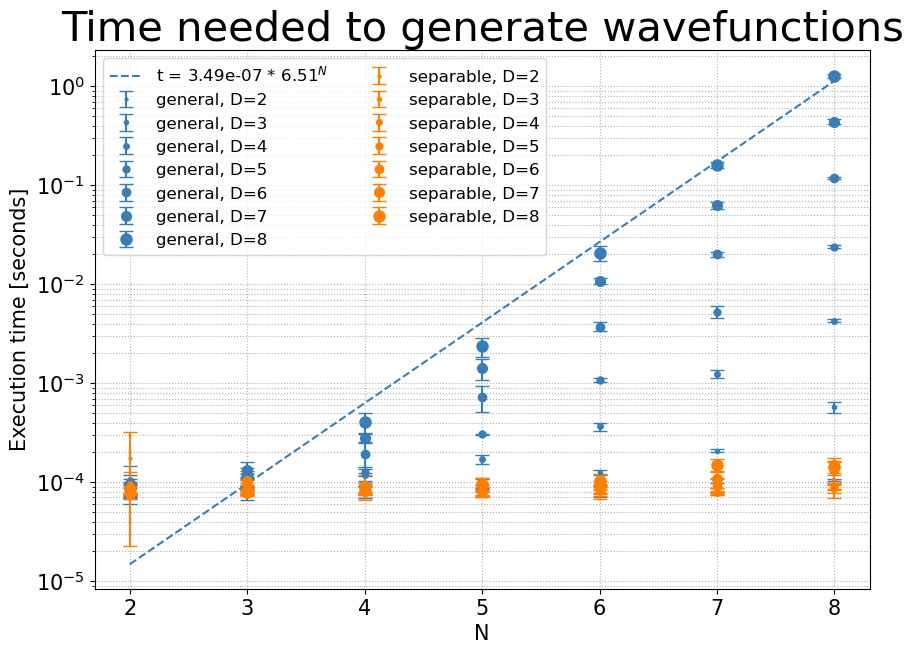

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
D_list = np.sort(np.unique(agg_df["D"]))

# plot all the desider plots
for i, type_ in enumerate(["general", "separable"]):
    for D_ in D_list:
        plot_df = agg_df[(agg_df["type"]==type_) & (agg_df["D"]==D_)]
        ax.errorbar(x="N", y="time_mean", yerr="time_std", data=plot_df,
                    fmt="o", c=color_palette[i], ms=D_, label=f"{type_}, D={D_}", capsize=5)

# fit general wavefunction with greatest D
fit_df = agg_df[(agg_df["type"]=="general") & (agg_df["D"]==np.max(D_))]
popt, pcov = curve_fit(f=exp_fit, xdata=fit_df["N"], ydata=fit_df["time_mean"], sigma=fit_df["time_std"], p0=[1.0, 1.0])
ax.plot(fit_df["N"], exp_fit(fit_df["N"], *popt), ls='dashed', label=f"t = {popt[0]:.2e} * {popt[1]:.2f}$^N$", c=color_palette[0])


ax.set_title("Time needed to generate wavefunctions", fontsize=30)
ax.set_xlabel("N", fontsize=15)
ax.set_ylabel("Execution time [seconds]", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.grid(True, which="both", linestyle=":")
ax.set_yscale("log")
ax.legend(fontsize=12, ncol=2)

if save_plots:
    fig.savefig("results/wavefunc_time.png", dpi=400, format='png')

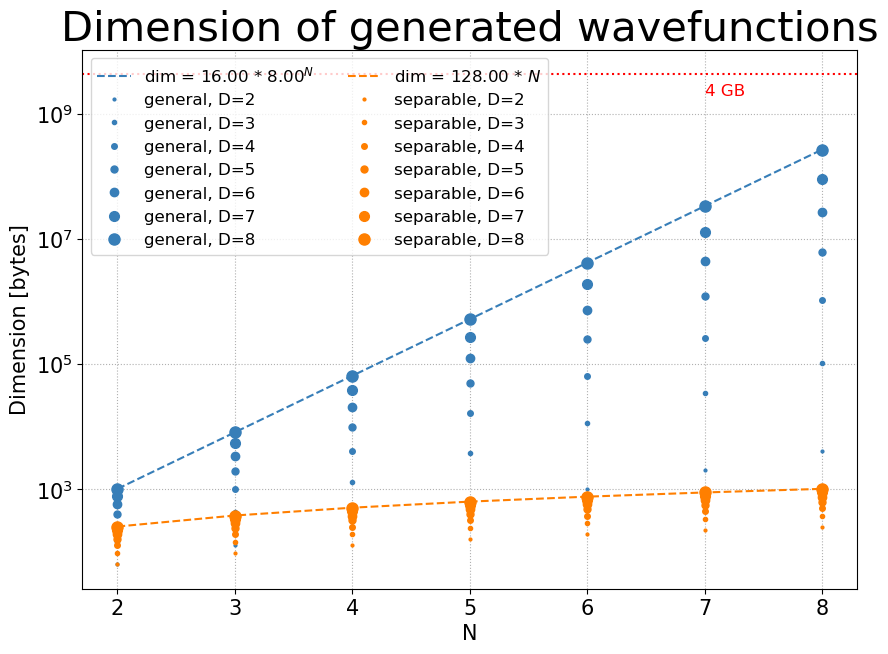

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
D_list = np.sort(np.unique(agg_df["D"]))

# plot all the desider plots
for i, type_ in enumerate(["general", "separable"]):
    for D_ in D_list:
        plot_df = agg_df[(agg_df["type"]==type_) & (agg_df["D"]==D_)]
        ax.errorbar(x="N", y="dim_bytes", data=plot_df,
                    fmt="o", c=color_palette[i], ms=D_, label=f"{type_}, D={D_}")


# fit general wavefunction with greatest D
fit_df = agg_df[(agg_df["type"]=="general") & (agg_df["D"]==np.max(D_))]
popt, pcov = curve_fit(f=exp_fit, xdata=fit_df["N"], ydata=fit_df["dim_bytes"], p0=[1.0, 1.0])
ax.plot(fit_df["N"], exp_fit(fit_df["N"], *popt), ls='dashed', label=f"dim = {popt[0]:.2f} * {popt[1]:.2f}$^N$", c=color_palette[0])

fit_df = agg_df[(agg_df["type"]=="separable") & (agg_df["D"]==np.max(D_))]
popt, pcov = curve_fit(f=lambda x,m: m*x, xdata=fit_df["N"], ydata=fit_df["dim_bytes"], p0=[1.0])
ax.plot(fit_df["N"], popt[0]*fit_df["N"], ls='dashed', label=f"dim = {popt[0]:.2f} * $N$", c=color_palette[1])


ax.set_title("Dimension of generated wavefunctions", fontsize=30)
ax.set_xlabel("N", fontsize=15)
ax.set_ylabel("Dimension [bytes]", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.grid(True, which="both", linestyle=":")
ax.axhline(4*2**30, c="r", ls=":")
ax.text(x=np.max(agg_df["N"])-1, y=1.8*2**30, s="4 GB", color="r", fontsize=12)
ax.set_yscale("log")

# set legend ordering manually
h, l = fig.gca().get_legend_handles_labels()
ax.legend(handles=[item for sublist in [[h[0]], h[2:9], [h[1]], h[9:]] for item in sublist],
          labels=[item for sublist in [[l[0]], l[2:9], [l[1]], l[9:]] for item in sublist],
          fontsize=12, ncol=2)

if save_plots:
    fig.savefig("results/wavefunc_dimension.png", dpi=400, format='png')

### Density matrix testing

In [100]:
densitymatrix_df = pd.read_csv("results/densitymatrix_perf.csv", header=0, dtype={"N":int, "D":int, "dim_bytes":int})
densitymatrix_df[:10]

,N,D,dim_bytes,time
0,2,2,256,0.000176
1,2,2,256,0.000084
2,2,2,256,0.000087
3,2,4,4096,0.000116
4,2,4,4096,0.000105
5,2,4,4096,0.000090
6,3,2,1024,0.000158
7,3,2,1024,0.000100
8,3,2,1024,0.000084
9,3,4,65536,0.000162


In [101]:
# groupby repetitions of the same configuration
# then take the average, std and rename columns 
agg_df = densitymatrix_df.groupby(["N", "D", "dim_bytes"]).agg(["mean", "std"])
agg_df.columns = ['_'.join(col) for col in agg_df.columns.to_flat_index().values]
agg_df.reset_index(inplace=True)
agg_df

,N,D,dim_bytes,time_mean,time_std
0,2,2,256,0.000116,0.000052
1,2,4,4096,0.000104,0.000013
2,3,2,1024,0.000114,0.000039
3,3,4,65536,0.000140,0.000028
4,4,2,4096,0.000091,0.000008
5,4,4,1048576,0.000580,0.000354
6,5,2,16384,0.000107,0.000026
7,5,4,16777216,0.006098,0.003283
8,6,2,65536,0.000130,0.000018
9,6,4,268435456,0.136956,0.002349


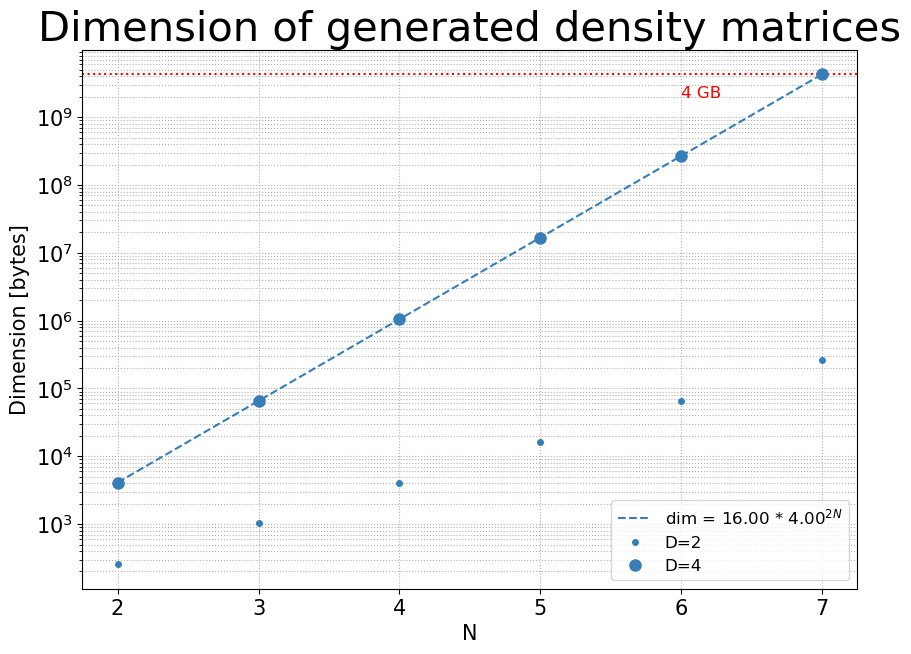

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
D_list = np.sort(np.unique(agg_df["D"]))

# plot all the desider plots
for D_ in D_list:
    plot_df = agg_df[agg_df["D"]==D_]
    ax.errorbar(x="N", y="dim_bytes", data=plot_df,
                fmt="o", c=color_palette[0], ms=2*D_, label=f"D={D_}", capsize=5)

# fit with greatest D
fit_df = agg_df[agg_df["D"]==np.max(D_)]
popt, pcov = curve_fit(f=exp_fit, xdata=fit_df["N"], ydata=fit_df["dim_bytes"], p0=[1.0, 1.0])
ax.plot(fit_df["N"], exp_fit(fit_df["N"], *popt), ls='dashed', label=f"dim = {popt[0]:.2f} * {np.sqrt(popt[1]):.2f}$^{{2N}}$", c=color_palette[0])


ax.set_title("Dimension of generated density matrices", fontsize=30)
ax.set_xlabel("N", fontsize=15)
ax.set_ylabel("Dimension [bytes]", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.grid(True, which="both", linestyle=":")
ax.axhline(4*2**30, c="r", ls=":")
ax.text(x=np.max(agg_df["N"])-1, y=1.8*2**30, s="4 GB", color="r", fontsize=12)
ax.set_yscale("log")
ax.legend(fontsize=12)

if save_plots:
    fig.savefig("results/densitymatrix_dimension.png", dpi=400, format='png')

### Partial trace testing

### Maximal entanglement test (D=2)

### Scaling of partial trace on half subsystem (D=2, Nred=N/2)